In [1]:
import scipy.io as sio
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import numpy as np
import mat73

In [2]:
mat_data = mat73.loadmat('../../indy_20161005_06.mat')

In [3]:
spikes_times = []

time = -1

for i in range(96):
    spike_time = mat_data['spikes'][i][0]
    if spike_time is not None:
        temp = np.argmax(spike_time)
        time = max(time, temp)
    spikes_times.append(spike_time)

In [4]:
import numpy as np

def calculate_direction_speed_acceleration(target_pos, cursor_pos, time_points):
    # 计算位移向量
    displacement_vector = target_pos - cursor_pos
    
    # 计算时间差
    time_diff = np.diff(time_points.flatten())  # 将时间点展平，然后计算差分

    # 计算速度向量
    velocity_vector = np.diff(cursor_pos, axis=0) / time_diff[:, np.newaxis]

    # 计算加速度向量
    acceleration_vector = np.diff(velocity_vector, axis=0) / time_diff[1:, np.newaxis]

    # 计算方向角
    direction_angle = np.arctan2(displacement_vector[:, 1], displacement_vector[:, 0])
    
    angle = np.degrees(direction_angle)
    
    # 将角度调整为在0到360度之间
    direction_angle = (angle + 360) % 360

    return direction_angle, velocity_vector, acceleration_vector


In [5]:
direction_angle, velocity_vector, acceleration_vector = calculate_direction_speed_acceleration(mat_data['target_pos'], mat_data['cursor_pos'], mat_data['t'])

# 打印结果
print("方向角：", direction_angle[0:5])
print("速度向量：", velocity_vector[0:5])
print("加速度向量：", acceleration_vector[0:5])

方向角： [123.72768334 123.72704591 123.72631505 123.7254781  123.7245241 ]
速度向量： [[-0.89040574  0.9283699 ]
 [-0.96429732  0.97968902]
 [-1.04123813  1.0275546 ]
 [-1.12127256  1.07309844]
 [-1.20332899  1.1168397 ]]
加速度向量： [[-18.47289425  12.82978005]
 [-19.23520359  11.96639343]
 [-20.00860625  11.38596127]
 [-20.5141088   10.93531526]
 [-20.47569891  10.44844992]]


In [6]:
def round_to_nearest(x, interval=0.004):
    return [int(round(num / interval) * 4) for num in x]

flat_data = []
for sublist in spikes_times:
    if sublist is not None:
        if sublist.size == 1:
            flat_data.append(sublist.item())
        else:
            for item in sublist:
                flat_data.append(item)
                
flat_data = round_to_nearest(flat_data)
print(flat_data[0:20])

[1285476, 1285520, 1285548, 1285724, 1285732, 1285752, 1285860, 1286064, 1286372, 1286436, 1286460, 1286472, 1286496, 1286516, 1286776, 1286912, 1286920, 1286948, 1287040, 1287092]


In [7]:
(mat_data["t"][-1] - mat_data["t"][0]) / 0.004 # 50 单位 = 0.2s

93500.0

In [8]:
# 将映射后的结果按照50为间隔进行处理
interval = 200
mapped_t = np.arange(1288000, 1288000 + 93501 * 4, interval)
count_per_interval = np.histogram(flat_data, bins=1871)

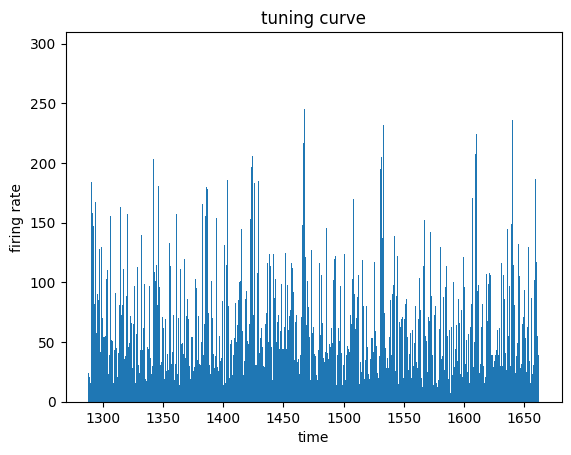

In [9]:
import matplotlib.pyplot as plt

# 绘制 count_per_interval 的柱状图
plt.bar(mapped_t / 1000, count_per_interval[0], width=interval / 1000, align='edge')

# 添加标签和标题
plt.xlabel('time')
plt.ylabel('firing rate')
plt.title('tuning curve')

# 显示图表
plt.show()


In [10]:
direction_angle_360 = [int(x) for x in direction_angle]

count_360 = [set() for _ in range(360)]

repeated_values = np.repeat(np.arange(0, 1871, 1), 50)

for i, angle in enumerate(direction_angle_360):
    count_360[angle].add(int(repeated_values[i]))

number_angle = [0 for i in range(360)]

for i in range(360):
    tmp = list(count_360[i])
    
    count = 0
    for j in tmp:
        count = count + count_per_interval[0][j]
        
    number_angle[i] = count

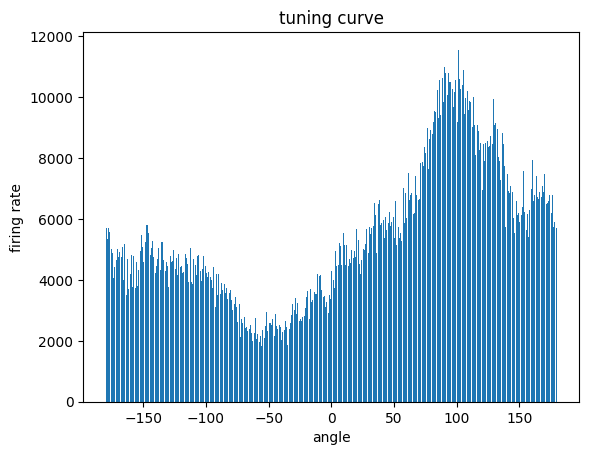

In [26]:
# 绘制 count_per_interval 的柱状图
plt.bar([i for i in range(-180, 180)], number_angle[int(len(number_angle) / 2):-1] + number_angle[0:int(len(number_angle) / 2) + 1], align='edge')

# 添加标签和标题
plt.xlabel('angle')
plt.ylabel('firing rate')
plt.title('tuning curve')

# 显示图表
plt.show()

In [12]:
def round_to_half(x):
    return [int(round(num * 2)) / 2 for num in x]

velocity_vector_xy = np.array(velocity_vector)

# 计算每个向量的长度
speeds_xy = np.linalg.norm(velocity_vector_xy, axis=1)

speed_half = round_to_half(speeds_xy / 100)

In [13]:
print(len(list(set(speed_half))))

13


In [14]:
count_v = [set() for _ in range(13)]
count_vs = [0 for _ in range(13)]

repeated_values = np.repeat(np.arange(0, 1871, 1), 50)

for i, speed in enumerate(speed_half):
    count_v[int(speed / 0.5)].add(int(repeated_values[i]))
    count_vs[int(speed / 0.5)] = count_vs[int(speed / 0.5)] + 1

number_v = [0 for i in range(13)]

for i in range(13):
    tmp = list(count_v[i])
    
    count = 0
    for j in tmp:
        count = count + count_per_interval[0][j]
        
    number_v[i] = count

print(number_v)
print(count_vs)

vv = [0 for _ in range(13)]

for i, k in enumerate(number_v):
    vv[i] = int(number_v[i] * 2 / count_vs[i])

[104414, 75888, 52655, 39749, 33139, 24347, 16150, 9955, 7256, 3290, 1540, 523, 55]
[53595, 16896, 7350, 4433, 3745, 3089, 1815, 1123, 845, 389, 149, 61, 10]


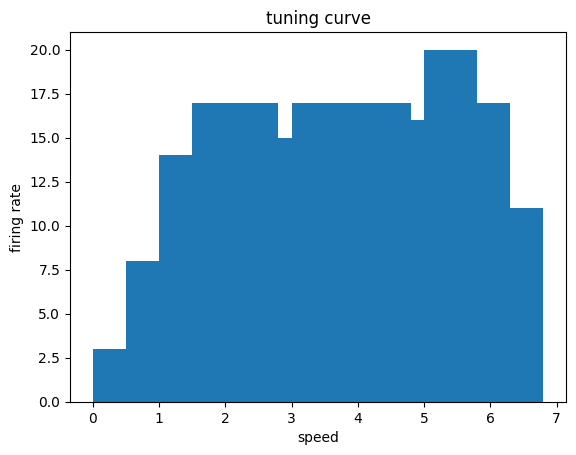

In [15]:
# 绘制 count_per_interval 的柱状图
plt.bar([i / 2 for i in range(13)], vv, align='edge')

# 添加标签和标题
plt.xlabel('speed')
plt.ylabel('firing rate')
plt.title('tuning curve')

# 显示图表
plt.show()

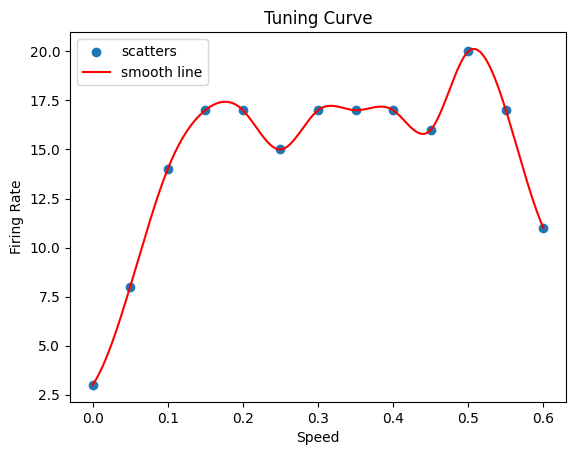

In [16]:
speed_range = [i / 20 for i in range(13)]

x_range = np.linspace(min(speed_range), max(speed_range), 500)
y_range = interp1d(speed_range, vv, kind='cubic')(x_range)

plt.scatter(speed_range, vv, label="scatters")
plt.plot(x_range, y_range, color='red', label="smooth line")

plt.title('Tuning Curve')
plt.xlabel('Speed')
plt.ylabel('Firing Rate')

plt.legend()
plt.show()

In [17]:
def round_to_half(x):
    return [int(round(num * 2)) / 2 for num in x]

acceleration_vector_xy = np.array(acceleration_vector)

# 计算每个向量的长度
accelerate_xy = np.linalg.norm(acceleration_vector_xy, axis=1)

accelerate_half = round_to_half(accelerate_xy / 100)

In [18]:
print(len(list(set(accelerate_half))))

156


In [19]:
print(max(list(set(accelerate_half))))
print(min(list(set(accelerate_half))))

86.5
0.0


In [20]:
count_a = [set() for _ in range(174)]
count_as = [0 for _ in range(174)]

repeated_values = np.repeat(np.arange(0, 1871, 1), 50)

for i, a in enumerate(accelerate_half):
    count_a[int(a / 0.5)].add(int(repeated_values[i]))
    count_as[int(a / 0.5)] = count_as[int(a / 0.5)] + 1

number_a = [0 for i in range(174)]

for i in range(13):
    tmp = list(count_v[i])
    
    count = 0
    for j in tmp:
        count = count + count_per_interval[0][j]
        
    number_a[i] = count

print(number_a)
print(count_as)

aa = [0 for _ in range(174)]

for i, k in enumerate(number_a):
    if count_as[i] == 0:
        aa[i] = 0
    else:
        aa[i] = int(number_a[i] * 2 / count_as[i])

[104414, 75888, 52655, 39749, 33139, 24347, 16150, 9955, 7256, 3290, 1540, 523, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[14103, 13222, 6923, 4783, 3773, 3109, 2818, 2497, 2248, 2126, 1841, 1682, 1537, 1399, 1468, 1344, 1320, 1210, 1134, 1049, 1025, 992, 937, 917, 893, 827, 824, 786, 774, 776, 714, 658, 697, 634, 612, 566, 603, 551, 523, 473, 473, 425, 422, 432, 393, 364, 354, 295, 299, 310, 299, 276, 261, 278, 230, 217, 209, 196, 168, 175, 179, 159, 159, 159, 151, 148, 150, 140, 145, 117, 115, 97, 76, 75, 63, 67, 68, 77, 59, 54, 51, 53, 51, 60, 40

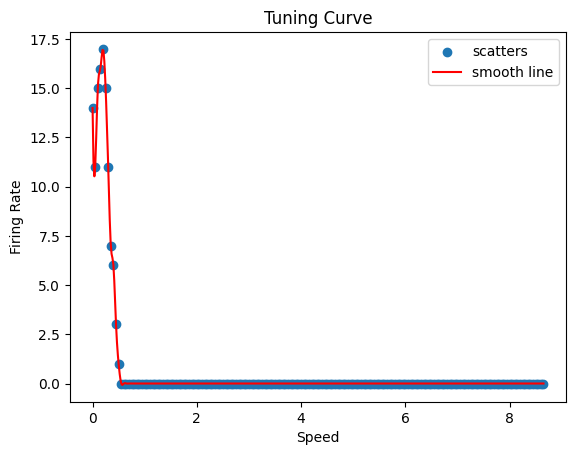

In [23]:
accelerate_range = [i / 20 for i in range(174)]

x_range = np.linspace(min(accelerate_range), max(accelerate_range), 500)
y_range = interp1d(accelerate_range, aa, kind='cubic')(x_range)

plt.scatter(accelerate_range, aa, label="scatters")
plt.plot(x_range, y_range, color='red', label="smooth line")

plt.title('Tuning Curve')
plt.xlabel('Speed')
plt.ylabel('Firing Rate')

plt.legend()
plt.show()

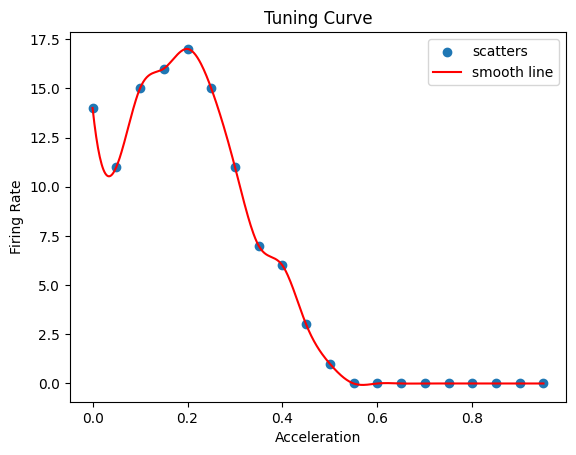

In [25]:
accelerate_range = [i / 20 for i in range(20)]

x_range = np.linspace(min(accelerate_range), max(accelerate_range), 500)
y_range = interp1d(accelerate_range, aa[0:20], kind='cubic')(x_range)

plt.scatter(accelerate_range, aa[0:20], label="scatters")
plt.plot(x_range, y_range, color='red', label="smooth line")

plt.title('Tuning Curve')
plt.xlabel('Acceleration')
plt.ylabel('Firing Rate')

plt.legend()
plt.show()